Prepare folders called S1A, S2A, S2B, S2C with their respective kml files.

# CODE

## Imports

In [17]:
import xml.etree.ElementTree as ET
from pathlib import Path
from datetime import datetime
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [18]:
# =============================================================================
# 1. KML Parsing Functions for S1 and S2
# =============================================================================
def parse_S1(file_path):
    """
    Parse a Sentinel-1 KML file using XML.
    
    Assumes each Placemark contains a <name> element with the acquisition datetime 
    (in ISO format) and a <coordinates> element containing comma-separated coordinates.
    
    Returns a list of dicts, each with keys:
      - 'time': a datetime object
      - 'polygon': a Shapely Polygon
    """
    tree = ET.parse(file_path)
    root = tree.getroot()
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    data_list = []
    
    for placemark in root.findall('.//kml:Placemark', ns):
        name_el = placemark.find('kml:name', ns)
        datetime_str = name_el.text.strip() if name_el is not None else None
        try:
            dt = datetime.fromisoformat(datetime_str) if datetime_str else None
        except Exception:
            dt = None
        
        coord_el = placemark.find('.//kml:coordinates', ns)
        polygon = None
        if coord_el is not None and coord_el.text:
            coord_text = coord_el.text.strip()
            polygon = parse_coordinates_to_polygon(coord_text)
        
        if dt is not None and polygon is not None:
            data_list.append({'time': dt, 'polygon': polygon})
    return data_list


def parse_S2(file_path):
    """
    Parse a Sentinel-2 KML file using XML.
    
    Assumes each Placemark contains a <TimeSpan> element with a <begin> tag holding the 
    acquisition datetime (in ISO format) and a <coordinates> element with coordinate strings.
    
    Returns a list of dicts, each with keys:
      - 'time': a datetime object
      - 'polygon': a Shapely Polygon
    """
    tree = ET.parse(file_path)
    root = tree.getroot()
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    data_list = []
    
    for placemark in root.findall('.//kml:Placemark', ns):
        timespan = placemark.find('kml:TimeSpan', ns)
        begin_el = timespan.find('kml:begin', ns) if timespan is not None else None
        datetime_str = begin_el.text.strip() if (begin_el is not None and begin_el.text) else None
        try:
            dt = datetime.fromisoformat(datetime_str) if datetime_str else None
        except Exception:
            dt = None
        
        coord_el = placemark.find('.//kml:coordinates', ns)
        polygon = None
        if coord_el is not None and coord_el.text:
            coord_text = coord_el.text.strip()
            polygon = parse_coordinates_to_polygon(coord_text)
        
        if dt is not None and polygon is not None:
            data_list.append({'time': dt, 'polygon': polygon})
    return data_list


def parse_coordinates_to_polygon(coord_str):
    """
    Convert a KML coordinate string into a Shapely Polygon.
    
    The coordinate string is assumed to contain one or more coordinate triples 
    (lon,lat,alt) separated by whitespace. Altitude is ignored.
    """
    points = coord_str.split()
    coords = []
    for point in points:
        parts = point.split(',')
        if len(parts) >= 2:
            try:
                lon = float(parts[0])
                lat = float(parts[1])
                coords.append((lon, lat))
            except Exception:
                continue
    # Ensure the polygon is closed
    if coords and coords[0] != coords[-1]:
        coords.append(coords[0])
    if len(coords) >= 3:
        return Polygon(coords)
    else:
        return None

In [19]:
# =============================================================================
# 2. File Reading Functions for a Given Sensor Folder
# =============================================================================
def read_kmls_from_folder(folder_path, sensor):
    """
    Reads all KML files in the specified folder using the sensor-specific parser.
    
    Parameters:
      folder_path (str or Path): Folder containing KML files.
      sensor (str): "S1" or "S2" to select the proper parser.
      
    Returns:
      list: A list of acquisition dictionaries (each with keys 'time' and 'polygon').
    """
    folder = Path(folder_path)
    data_all = []
    for file_path in folder.glob("*.kml"):
        if sensor == "S1":
            data = parse_S1(file_path)
        elif sensor == "S2":
            data = parse_S2(file_path)
        else:
            data = []
        data_all.extend(data)
    return data_all

In [20]:
# =============================================================================
# 3. Filtering and Grouping
# =============================================================================
def filter_by_aoi(acquisitions, aoi_polygon):
    """
    Filters the acquisitions to only those that intersect the AOI.
    
    Parameters:
      acquisitions (list): List of dictionaries with a 'polygon' key.
      aoi_polygon (Polygon): AOI as a Shapely Polygon.
    
    Returns:
      list: Filtered acquisitions.
    """
    return [acq for acq in acquisitions if acq['polygon'].intersects(aoi_polygon)]


def group_acquisitions_by_date(acquisitions):
    """
    Groups acquisitions by the date (year-month-day) of the acquisition time.
    
    Parameters:
      acquisitions (list): List of dictionaries, each with a 'time' key.
    
    Returns:
      dict: Dictionary mapping date (datetime.date) to list of acquisitions.
    """
    grouped = {}
    for acq in acquisitions:
        date = acq['time'].date()
        if date not in grouped:
            grouped[date] = []
        # Avoid duplicates by comparing the polygon's WKT and the acquisition time.
        if not any(acq['polygon'].wkt == existing['polygon'].wkt and acq['time'] == existing['time'] 
                   for existing in grouped[date]):
            grouped[date].append(acq)
    return grouped

In [21]:
# =============================================================================
# 4. Plotting with Cartopy
# =============================================================================
def plot_acquisitions(aoi_polygon, s1_grouped, s2_grouped):
    """
    For every day that has both S1 and S2 acquisitions, create a plot showing:
      - AOI (black)
      - S1 footprints (red)
      - S2 footprints (blue)
      
    The plot title includes the date and the observation times.
    
    Parameters:
      aoi_polygon (Polygon): AOI as a Shapely polygon.
      s1_grouped (dict): Dictionary mapping date to list of S1 acquisitions.
      s2_grouped (dict): Dictionary mapping date to list of S2 acquisitions.
    """
    common_dates = sorted(set(s1_grouped.keys()).intersection(s2_grouped.keys()))
    for date in common_dates:
        s1_data = s1_grouped[date]
        s2_data = s2_grouped[date]
        s1_times = sorted({acq['time'].strftime("%H:%M:%S") for acq in s1_data})
        s2_times = sorted({acq['time'].strftime("%H:%M:%S") for acq in s2_data})
        title = f"{date} - S1: {', '.join(s1_times)}; S2: {', '.join(s2_times)}"
        
        fig = plt.figure(figsize=(10, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_title(title)
        
        # Plot the AOI in black.
        x_aoi, y_aoi = aoi_polygon.exterior.xy
        ax.plot(x_aoi, y_aoi, color='black', linewidth=2, label='AOI')
        
        # Plot S1 footprints in red.
        for acq in s1_data:
            poly = acq['polygon']
            if poly is not None:
                x, y = poly.exterior.xy
                ax.plot(x, y, color='red', linewidth=1, label='S1 Footprint')
                
        # Plot S2 footprints in blue.
        for acq in s2_data:
            poly = acq['polygon']
            if poly is not None:
                x, y = poly.exterior.xy
                ax.plot(x, y, color='blue', linewidth=1, label='S2 Footprint')
        
        # Consolidate legend entries.
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        ax.coastlines()
        plt.show()


In [22]:
# =============================================================================
# 5. Extracting and Saving Occurrence Data
# =============================================================================
def extract_occurrences(s1_grouped, s2_grouped):
    """
    Extracts occurrences (common dates with S1 and S2 acquisitions) and computes 
    the time (in days) between consecutive occurrences.
    
    Returns a list of dictionaries, each containing:
      - 'date': the occurrence date
      - 'S1_times': comma-separated string of S1 observation times
      - 'S2_times': comma-separated string of S2 observation times
      - 'delta_days': days elapsed since the previous occurrence (None for the first)
    """
    common_dates = sorted(set(s1_grouped.keys()).intersection(s2_grouped.keys()))
    occurrences = []
    for date in common_dates:
        s1_data = s1_grouped[date]
        s2_data = s2_grouped[date]
        s1_times = sorted({acq['time'].strftime("%H:%M:%S") for acq in s1_data})
        s2_times = sorted({acq['time'].strftime("%H:%M:%S") for acq in s2_data})
        occurrences.append({
            'date': date,
            'S1_times': ', '.join(s1_times),
            'S2_times': ', '.join(s2_times),
            'delta_days': None  # will fill in later
        })
    
    # Compute time differences (in days) between consecutive occurrences.
    for i in range(1, len(occurrences)):
        delta = (occurrences[i]['date'] - occurrences[i-1]['date']).days
        occurrences[i]['delta_days'] = delta
    return occurrences


def save_occurrences(occurrences, output_file):
    """
    Saves the occurrence information to a CSV file.
    
    Parameters:
      occurrences (list): List of occurrence dictionaries.
      output_file (str): Path to the CSV file to be written.
    """
    df = pd.DataFrame(occurrences)
    df.to_csv(output_file, index=False)
    print(f"Occurrences saved to {output_file}")

## Main

In [23]:
# =============================================================================
# 6. Main Processing Function
# =============================================================================
def main(aoi_coords, base_dir, occurrences_file="occurrences.csv"):
    """
    Processes KML files from sensor subfolders (S1A, S2A, S2B, S2C):
      - Reads and parses KML files.
      - Filters acquisitions by AOI.
      - Groups acquisitions by date.
      - Visualizes the acquisitions.
      - Extracts occurrence data and saves it to a CSV file.
    
    Parameters:
      aoi_coords (list): List of (lon, lat) tuples defining the AOI.
      base_dir (str or Path): Directory containing subfolders S1A, S2A, S2B, S2C.
      occurrences_file (str): Filename to save occurrence information.
    """
    # Create AOI polygon.
    aoi_polygon = Polygon(aoi_coords)
    
    # Process Sentinel-1A acquisitions.
    s1_folder = Path(base_dir) / "S1A"
    s1_data = read_kmls_from_folder(s1_folder, sensor="S1")
    s1_data = filter_by_aoi(s1_data, aoi_polygon)
    s1_grouped = group_acquisitions_by_date(s1_data)
    
    if not s1_grouped:
        print("No S1A acquisitions found in the AOI.")
        return
    
    # Process Sentinel-2 acquisitions (S2A, S2B, S2C).
    s2_all = []
    for sensor_folder in ["S2A", "S2B", "S2C"]:
        folder = Path(base_dir) / sensor_folder
        data = read_kmls_from_folder(folder, sensor="S2")
        data = filter_by_aoi(data, aoi_polygon)
        s2_all.extend(data)
    s2_grouped = group_acquisitions_by_date(s2_all)
    
    if not s2_grouped:
        print("No S2 acquisitions found in the AOI.")
        return
    
    # Plot acquisitions for dates with both S1 and S2 data.
    plot_acquisitions(aoi_polygon, s1_grouped, s2_grouped)
    
    # Extract occurrence information and save it.
    occurrences = extract_occurrences(s1_grouped, s2_grouped)
    save_occurrences(occurrences, occurrences_file)

# USAGE

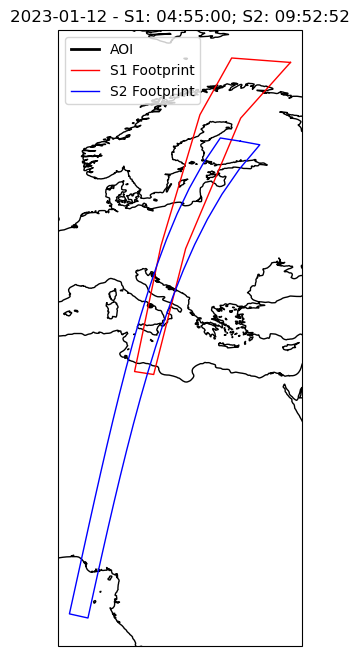

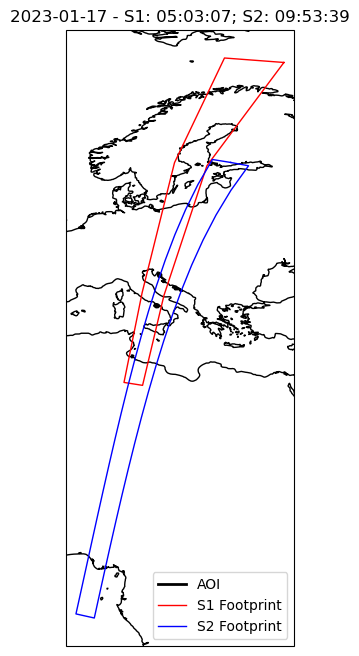

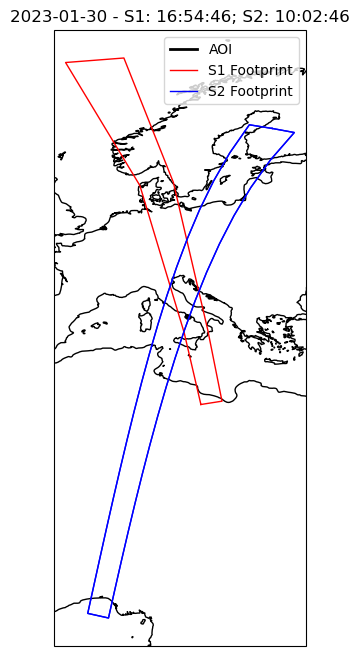

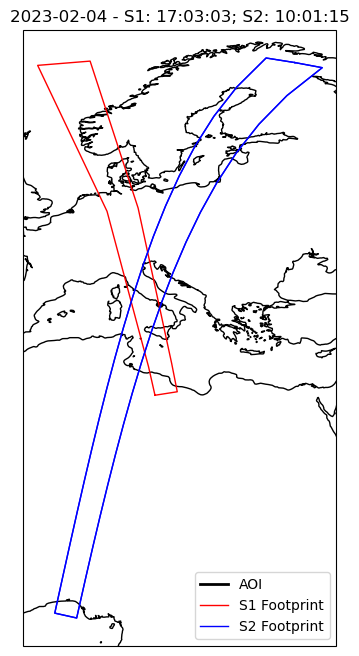

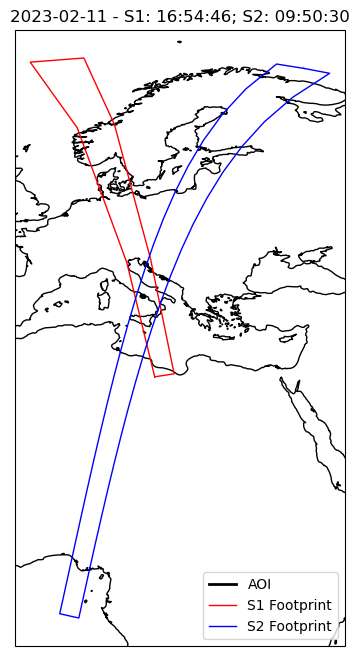

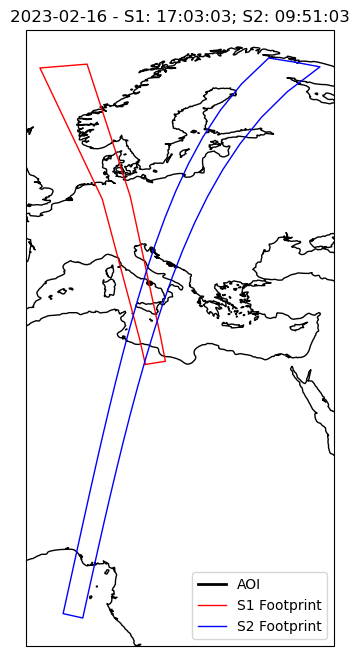

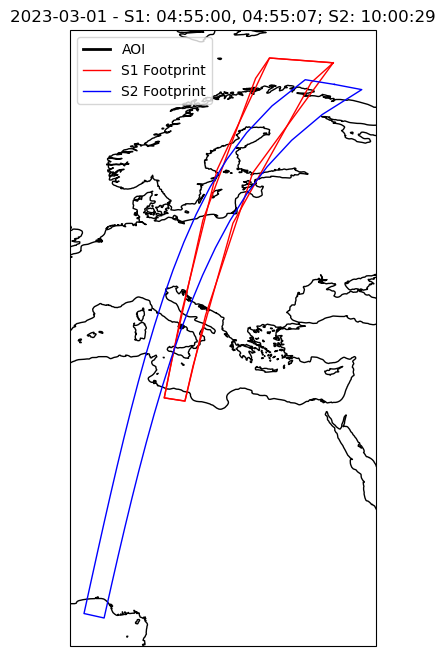

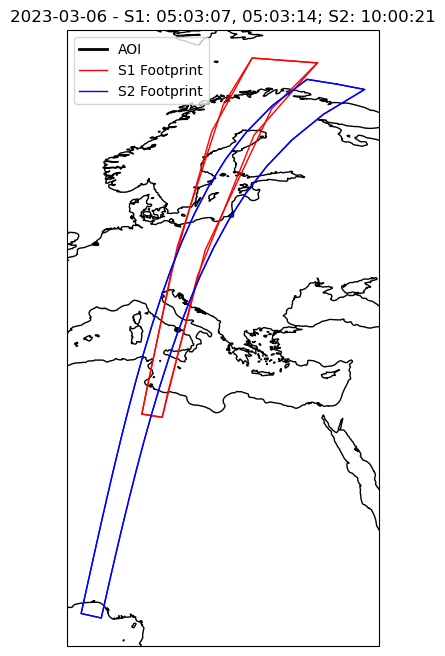

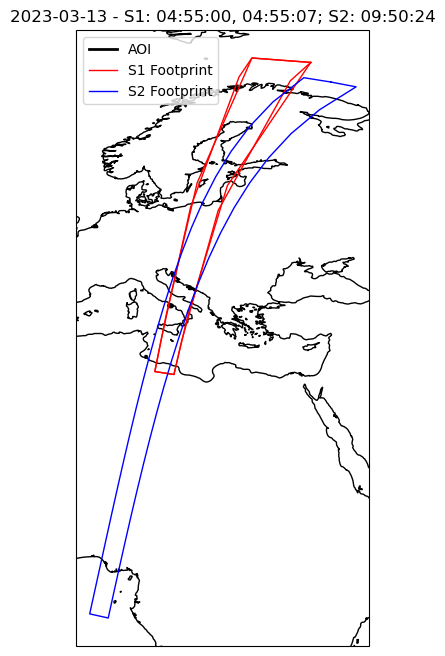

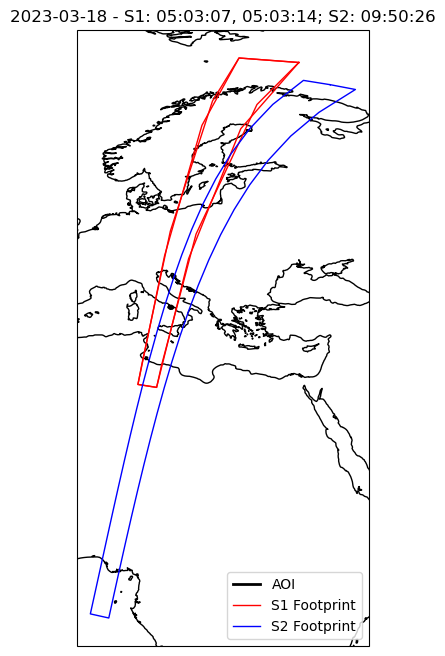

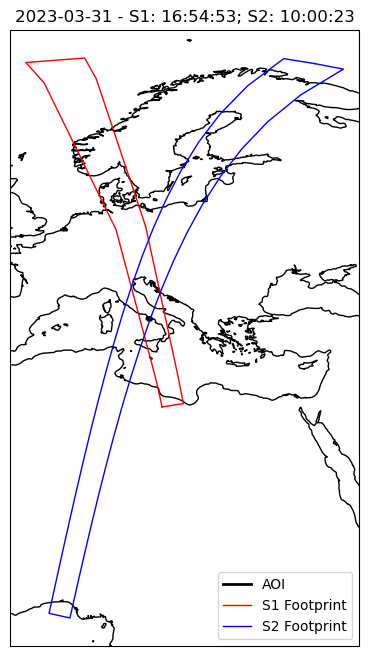

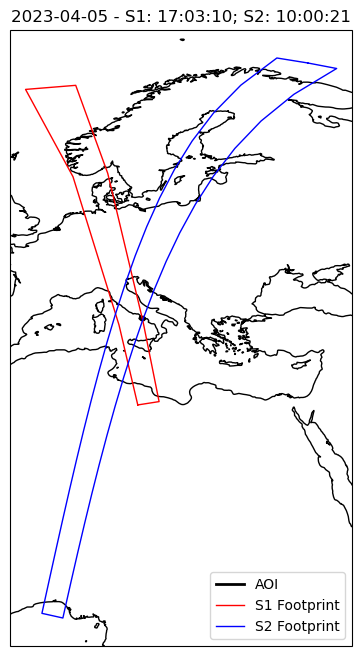

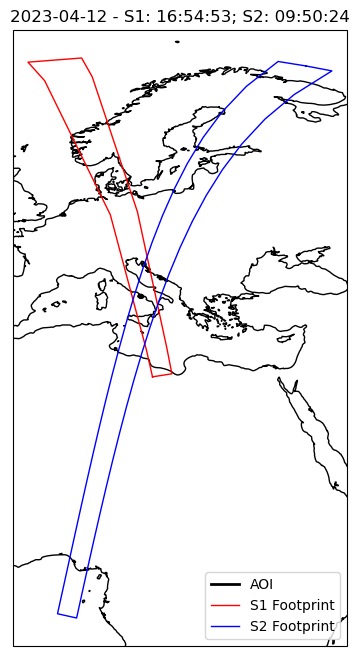

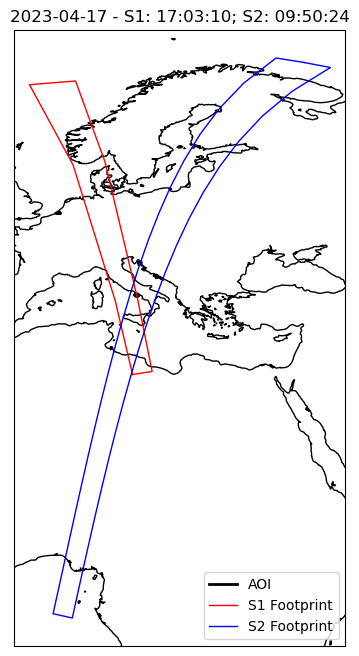

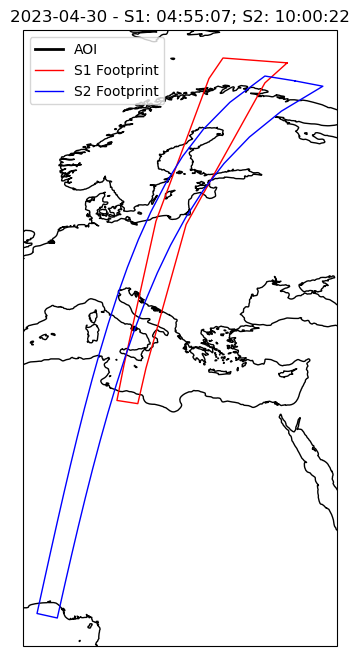

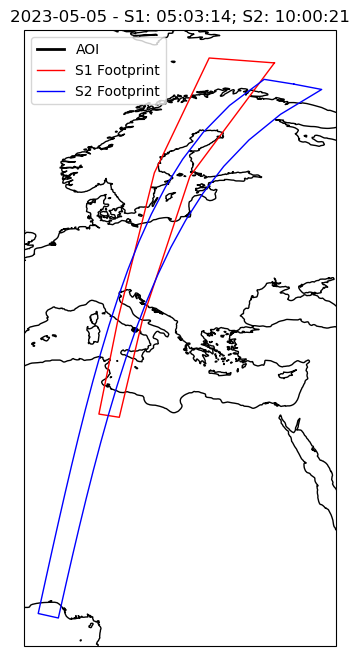

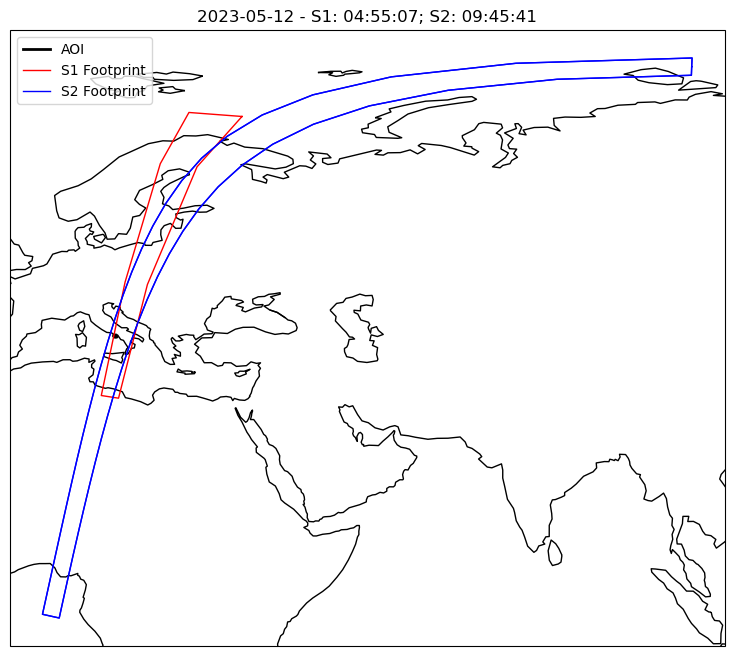

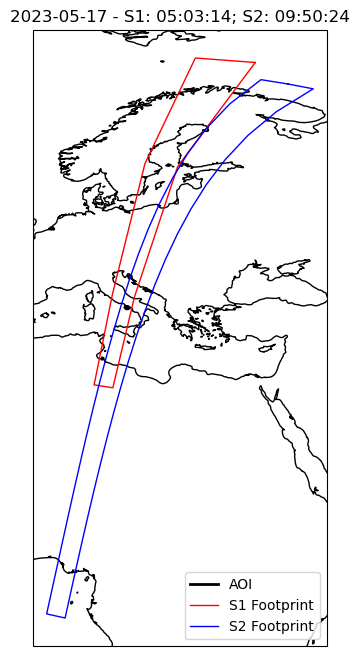

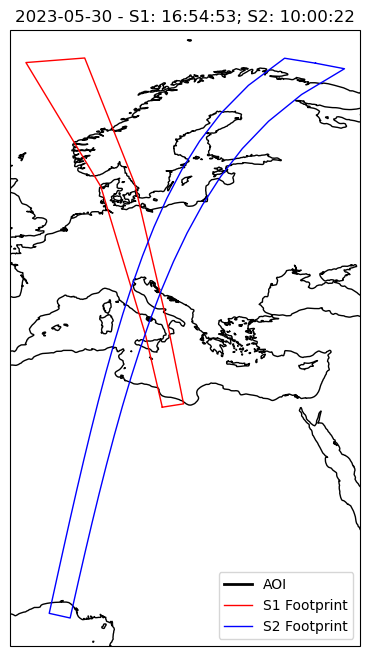

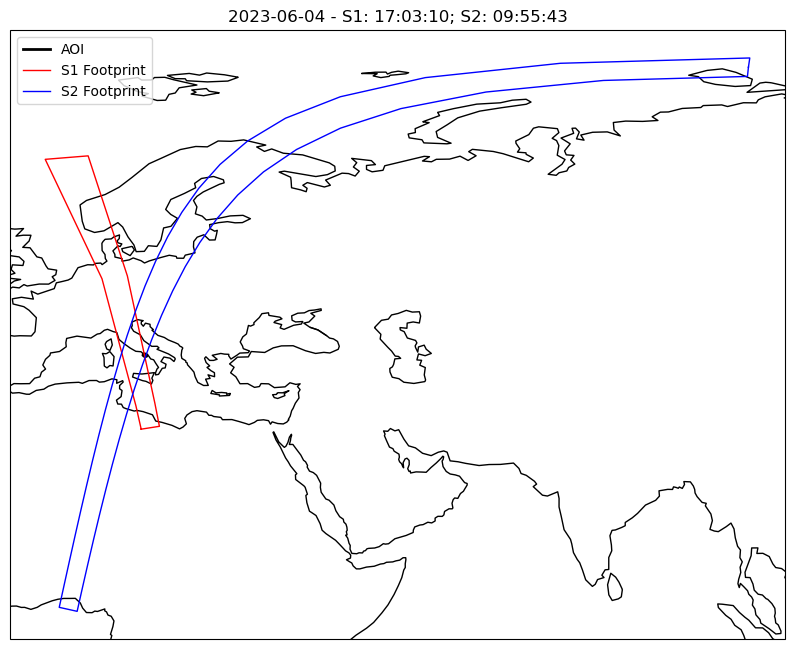

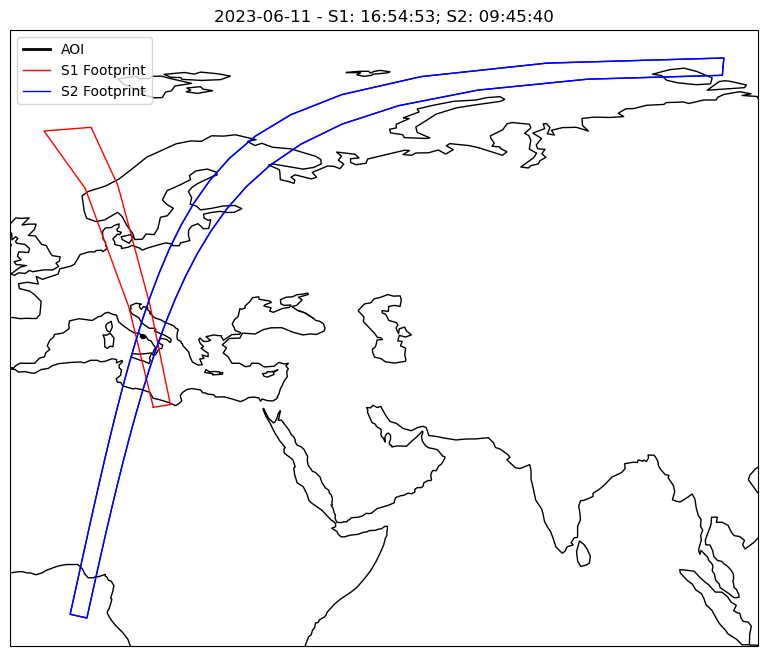

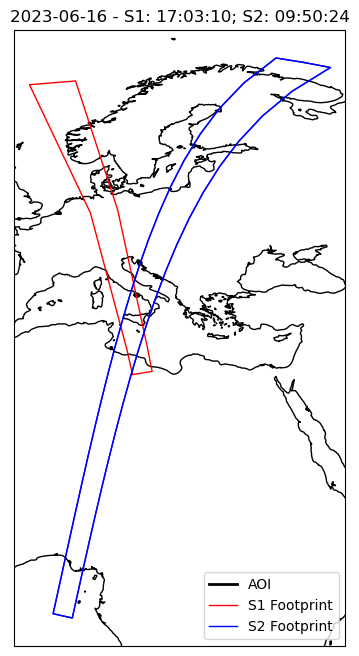

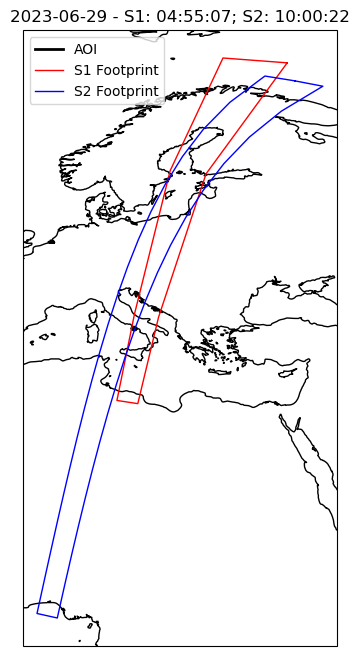

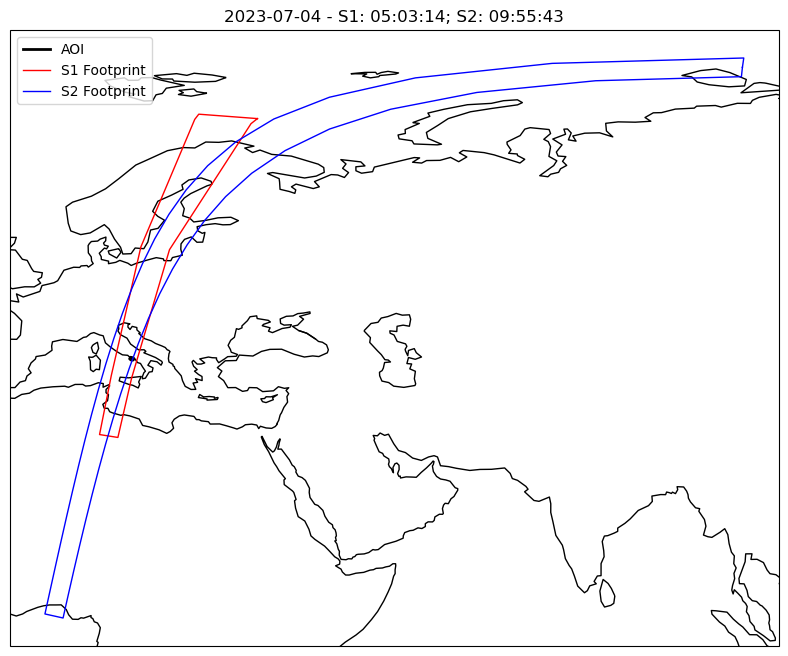

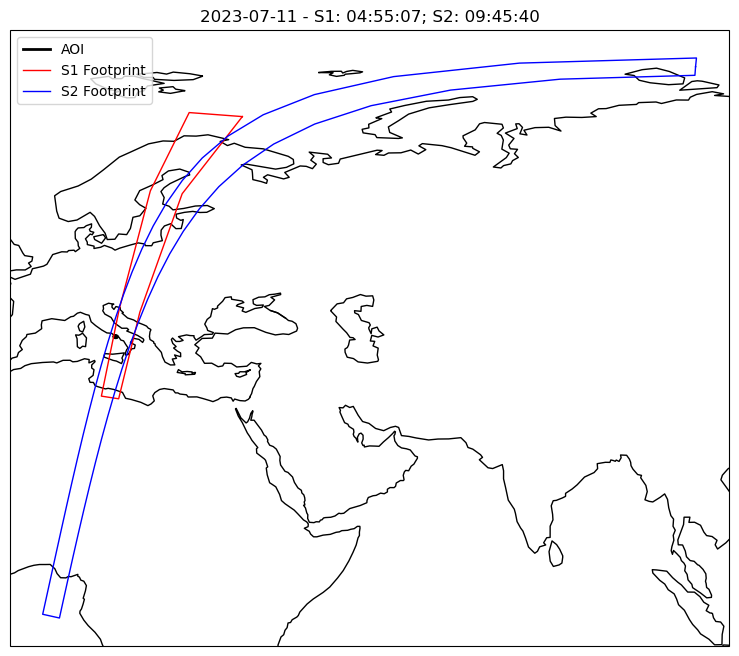

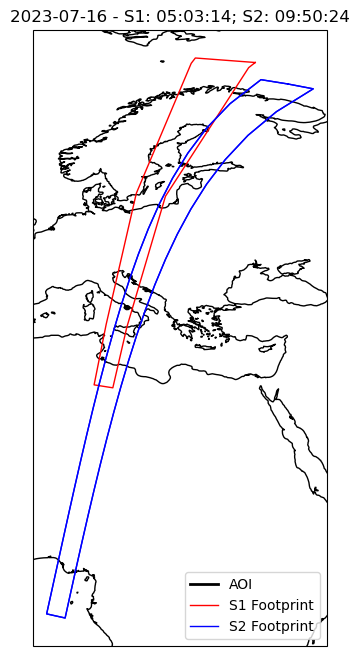

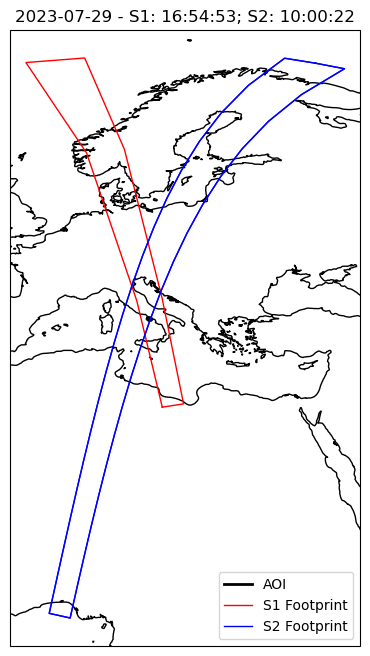

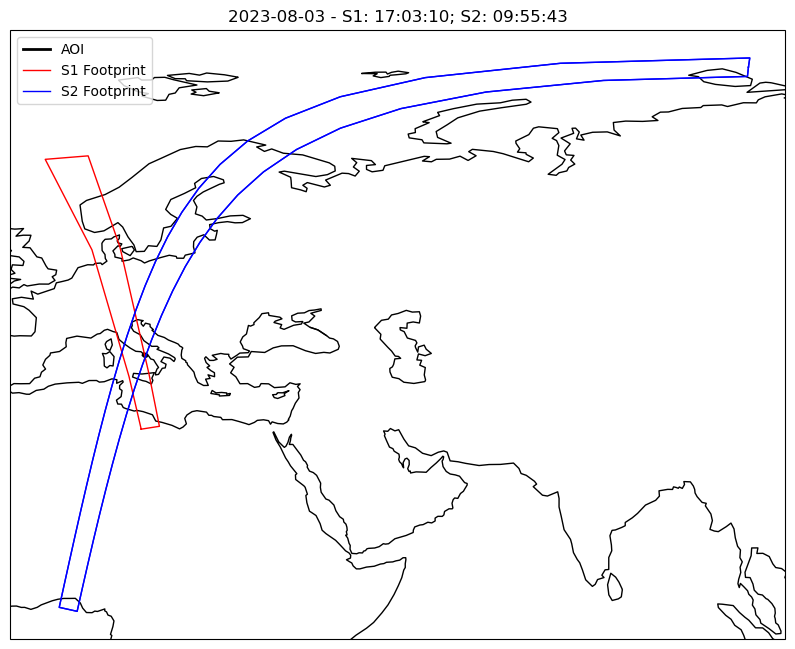

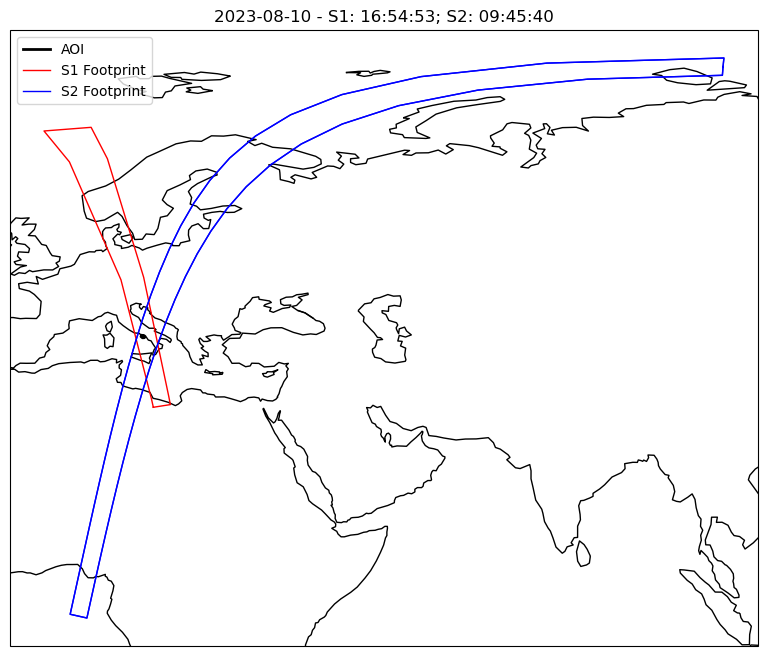

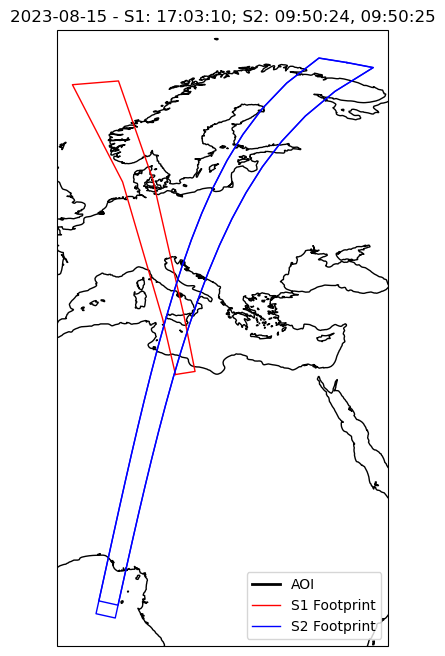

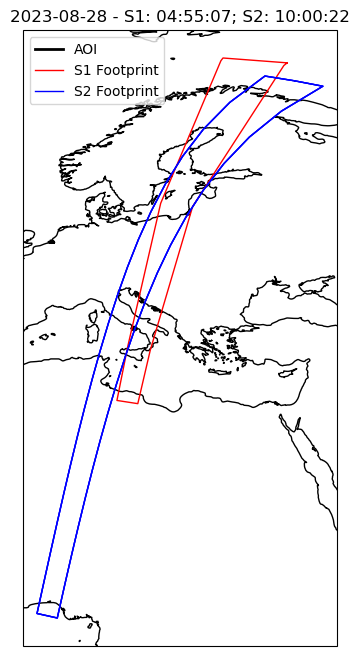

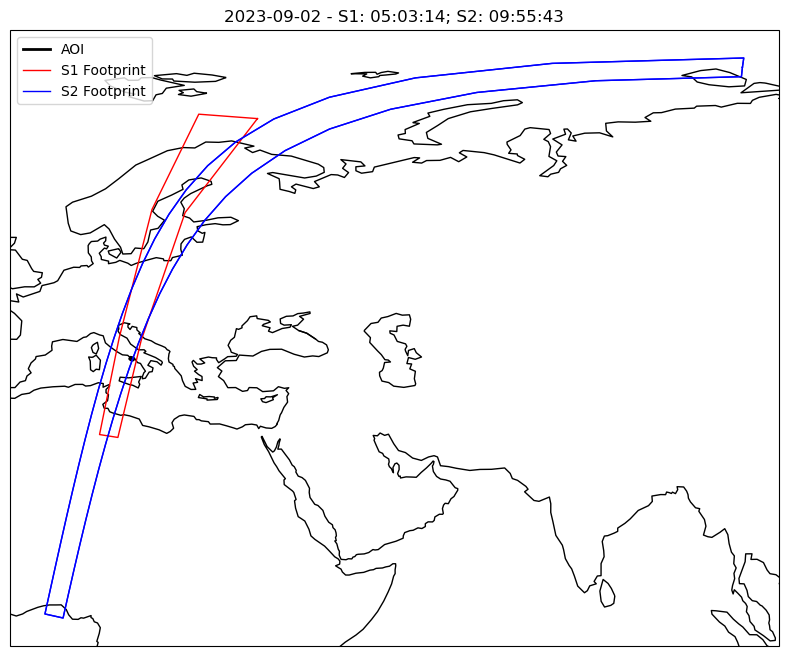

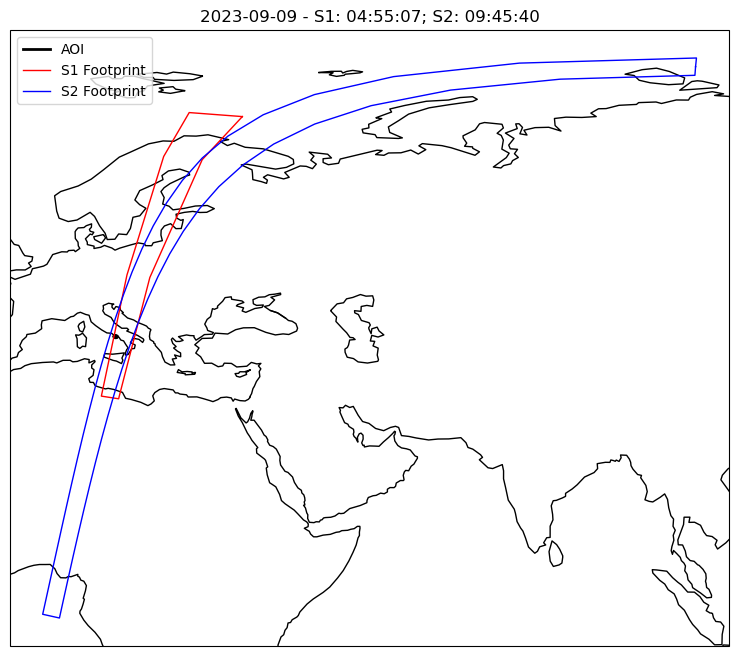

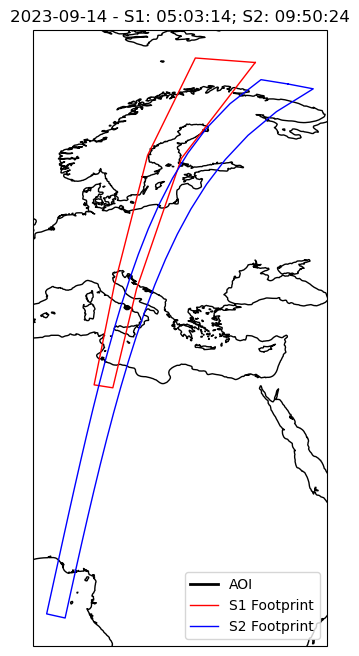

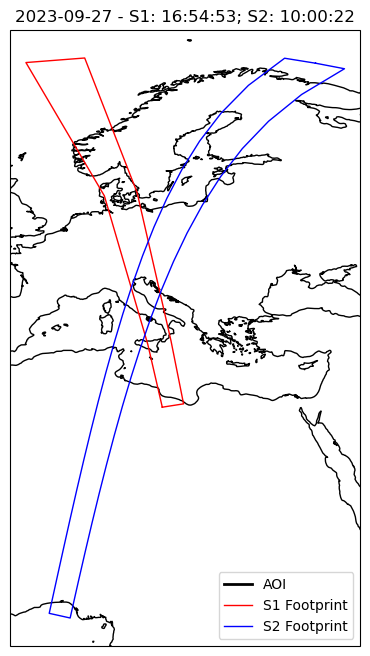

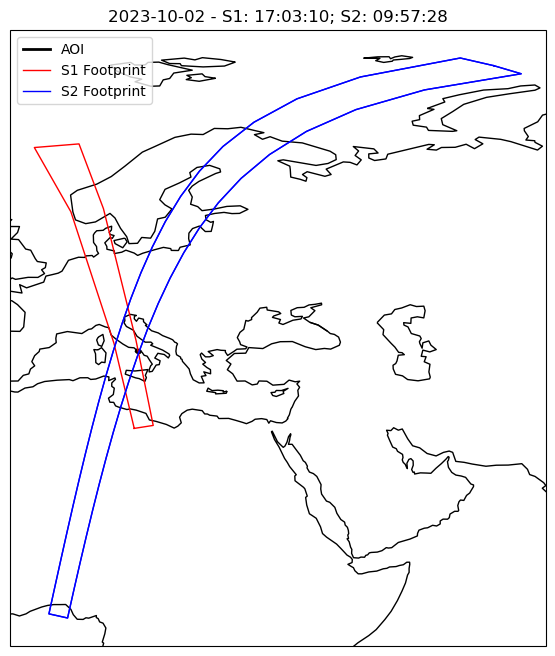

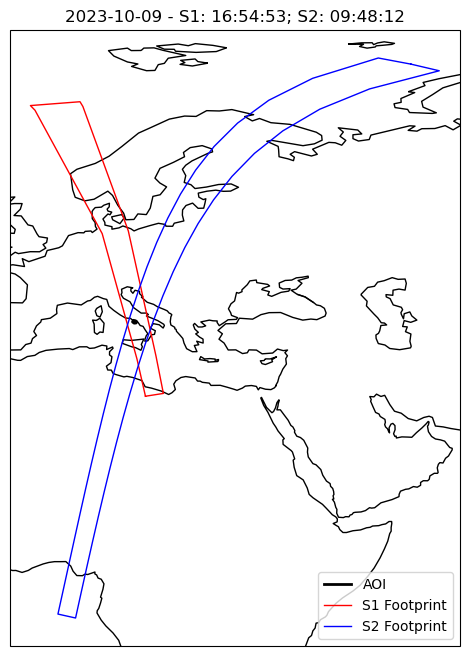

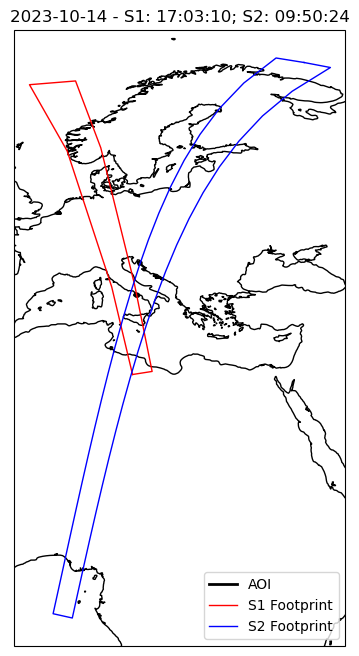

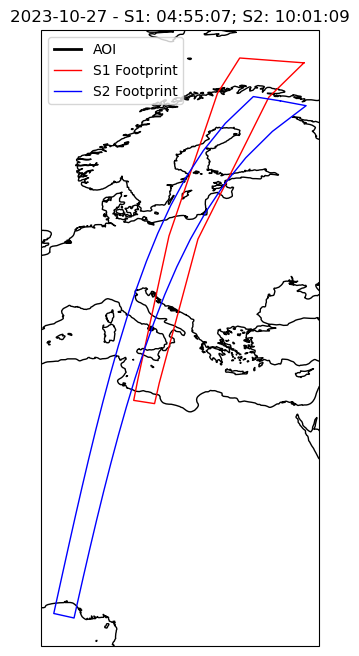

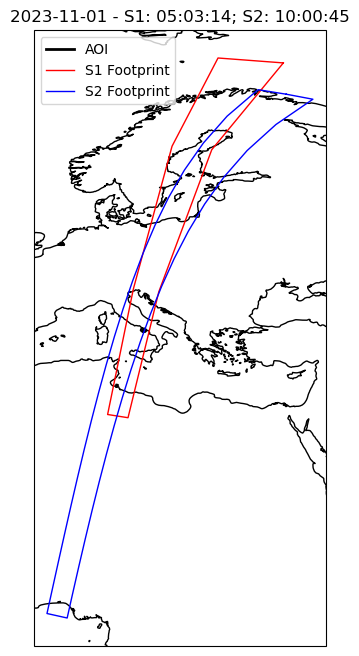

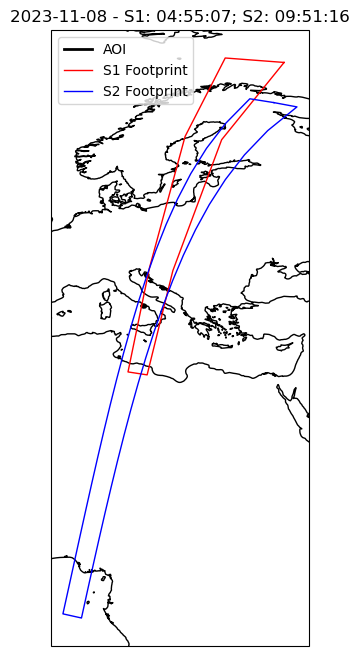

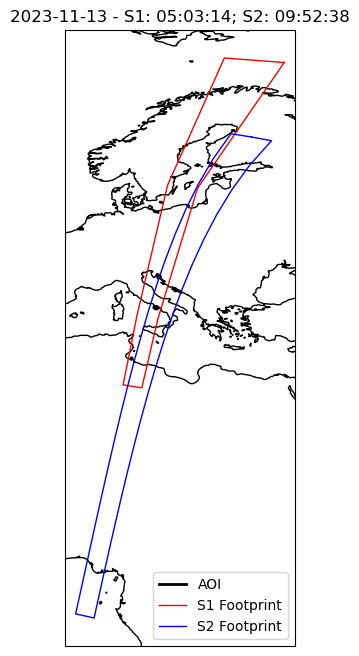

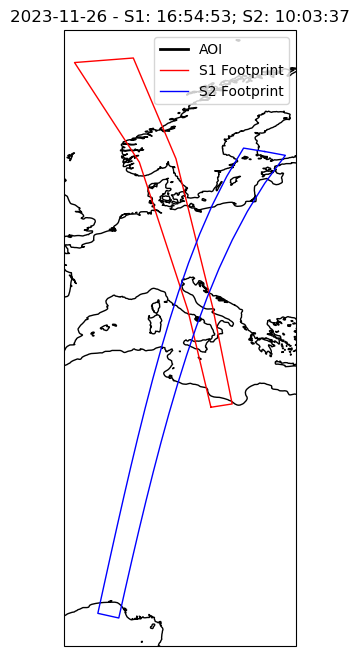

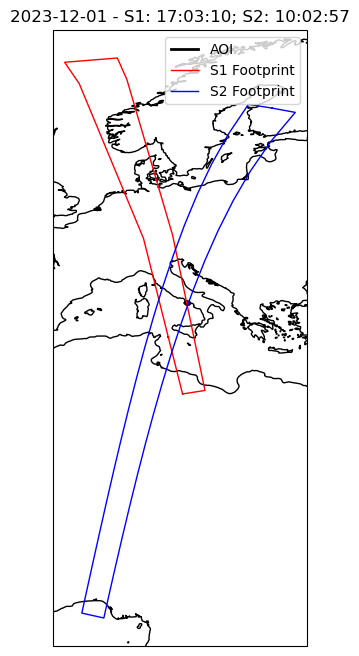

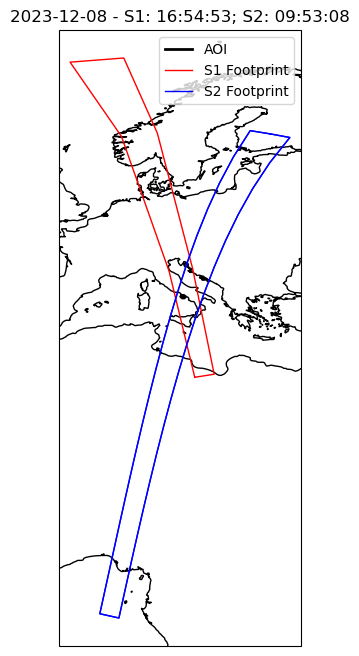

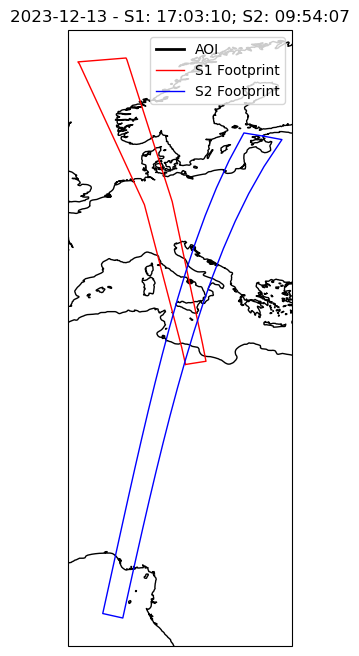

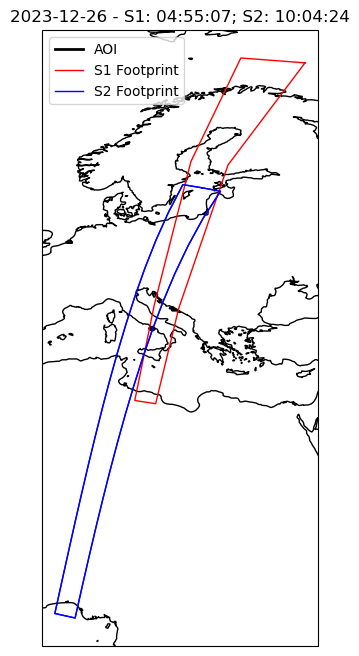

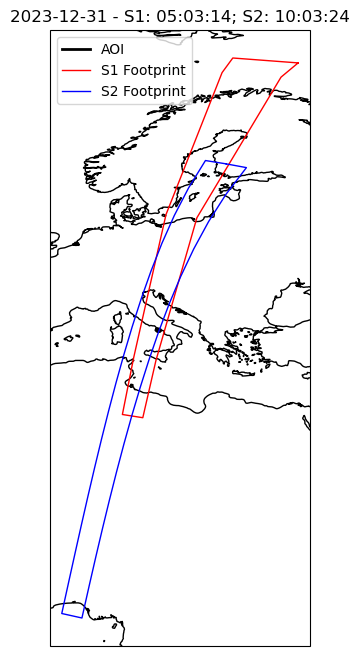

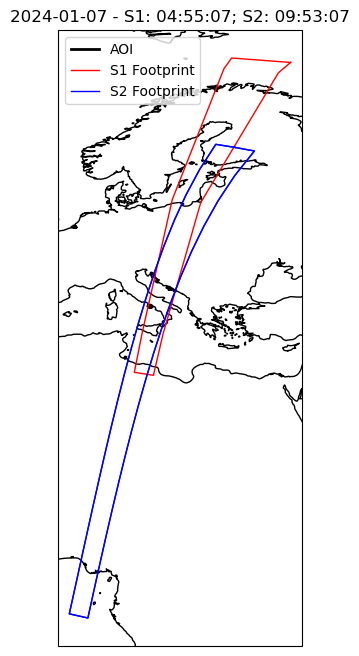

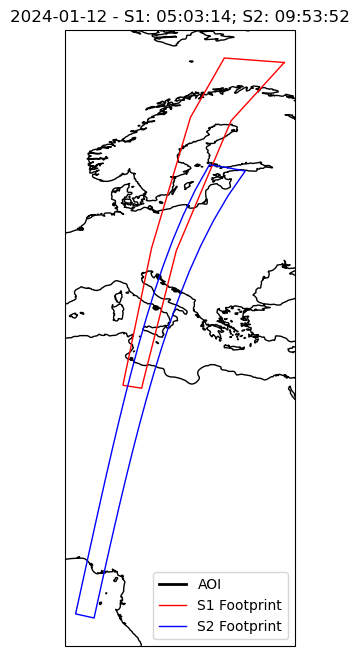

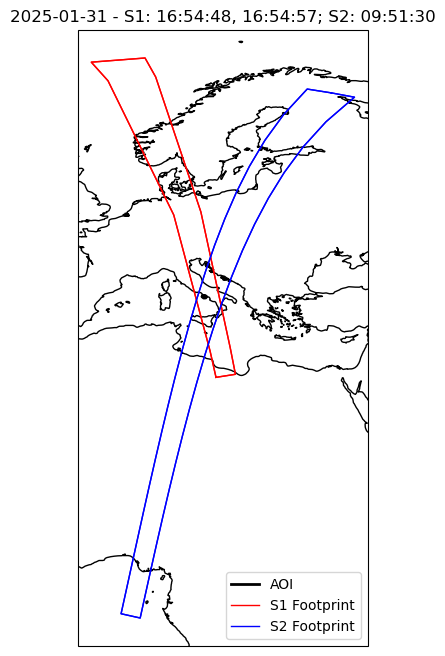

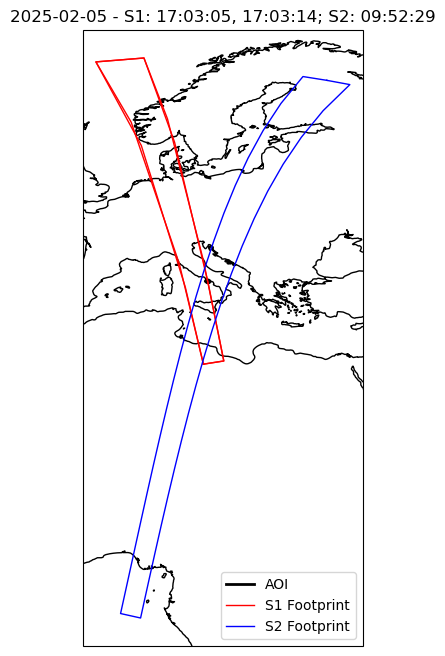

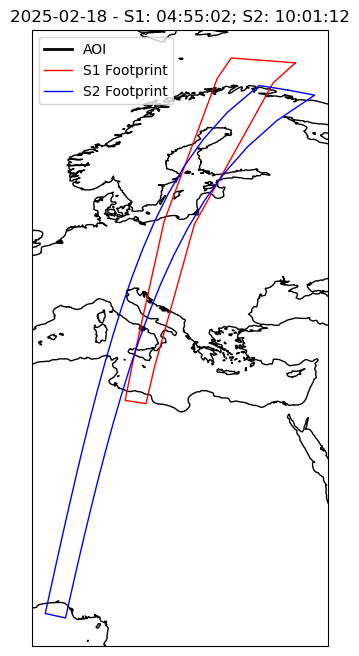

Occurrences saved to occurrences.csv


In [24]:
# AOI
'''
aoi_coords = [ # Genova
(8.774788509289269,44.46034184396458),
(8.680942232377792,44.37852145984363),
(8.76004257347522,44.29391461049305),
(8.90113523494634,44.27469539238287),
(9.062722495661992,44.25799729923898),
(9.147387481701056,44.39361997626863),
(9.057538598648902,44.43279748412667),
(8.892173162740907,44.45873479155792),
(8.774788509289269,44.46034184396458)
]

'''
aoi_coords = [ # Napoli
(14.02708084616117,40.85443981269849),
(13.89265628410081,40.69905736539984),
(14.12515632114292,40.50950766550351),
(14.39438135828544,40.53135756297827),
(14.52730162533469,40.7090851844846),
(14.2994442327474,40.87129233179456),
(14.02708084616117,40.85443981269849)
]

# Base directory should contain subfolders: S1A, S2A, S2B, S2C
base_dir = "."

main(aoi_coords, base_dir, occurrences_file="occurrences.csv")
